In [1]:
# usual imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

sys.path.append("../")

In [7]:
# pull the checkpoint from the regression experiment

sd = torch.load('/home/paulw/projects/TRUSnet-1/logs/experiments/runs/from_vicreg_position_regression_full_prostate_uva600_crceo428_finetune_false/2022-12-09_11-34-19/checkpoints/epoch_023.ckpt')

In [8]:
sd = sd['state_dict']

In [29]:
# function to extract keys with give prefix and consume prefix
def extract_keys_with_prefix(state_dict, prefix):
    keys = [k for k in state_dict.keys() if k.startswith(prefix)]

    out = {}
    for k in keys:
        # replace only first occurence of prefix
        new_key = k.replace(prefix, '', 1)
        out[new_key] = state_dict[k]

    return out

backbone_sd = extract_keys_with_prefix(sd, 'backbone.backbone.')
from src.modeling.mlp import MLPRegressor
regressor = MLPRegressor(512, 128, 128)
regressor.load_state_dict(extract_keys_with_prefix(sd, 'axial_regressor.'))

<All keys matched successfully>

In [30]:
from src.modeling.registry import create_model
backbone = create_model('resnet10_feature_extractor')
backbone.load_state_dict(backbone_sd)

<All keys matched successfully>

In [98]:
from src.data.exact.transforms import TransformV3, Normalize
T = TransformV3()

In [38]:
from src.data.exact.patient import ExactPatient
patient = ExactPatient.sample_patient()

In [45]:
core = patient.get_cores(as_list=True)[0] 

In [51]:
patch_view = core.get_patch_view()

In [60]:
axial_depth_prediction = {}

# pack view into single batch
patch = [] 
pos = []

for patch_, pos_ in patch_view:
    patch.append(T(patch_))
    pos.append(torch.tensor(pos_))

patch = torch.stack(patch)
pos = torch.stack(pos)

backbone.eval()
regressor.eval()

# get features
with torch.no_grad():
    features = backbone(patch)
    axial_depth_prediction = regressor(features)


In [61]:
axial_depth_prediction, pos

(tensor([[ 3.9658],
         [ 4.4351],
         [ 6.3299],
         ...,
         [33.2297],
         [34.1506],
         [34.3562]]),
 tensor([[ 0,  5,  0,  5],
         [ 0,  5,  1,  6],
         [ 0,  5,  2,  7],
         ...,
         [23, 28, 39, 44],
         [23, 28, 40, 45],
         [23, 28, 41, 46]]))

In [ ]:
from src.lightning.datamodules.exact_datamodule import PatchDataModuleForSupervisedLearning
PatchDataModuleForSupervisedLearning(
    
)

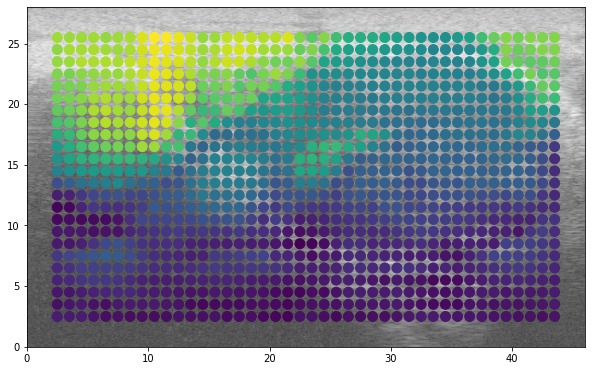

In [104]:

# make a function to do this for a given core
def plot_core(core, regressor, backbone, T):
    # get bmode 
    if not core.bmode_is_downloaded:
        core.download_bmode()
    bmode = core.bmode

    # pack view into single batch
    patch = [] 
    pos = []

    for patch_, pos_ in core.get_patch_view():
        patch.append(T(patch_))
        pos.append(torch.tensor(pos_))

    patch = torch.stack(patch)
    pos = torch.stack(pos) 

    # get features
    with torch.no_grad():
        features = backbone(patch)
        axial_depth_prediction = regressor(features)

    # plot the bmode with the predicted axial depth for each patch
    # plot it next to the bmode and overlaid over the bmode
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(bmode, cmap='gray', extent=[0, 46, 0, 28])

    # compute center of each patch
    centers = np.zeros((pos.shape[0], 2))
    centers[:, 0] = (pos[:, 0] + pos[:, 1]) * 0.5
    centers[:, 1] = (pos[:, 2] + pos[:, 3]) * 0.5

    # plot the predicted axial depth for each patch
    # colors should be between 0 and 28
    ax.scatter(centers[:, 1], centers[:, 0], c=axial_depth_prediction, cmap='viridis', s=100)
    # show the colorbar on the right 
    #fig.colorbar(ax.collections[0], ax=ax, label='Predicted Axial Depth (mm)')
    
    return centers, axial_depth_prediction

centers, depth = plot_core(core, regressor, backbone, T)

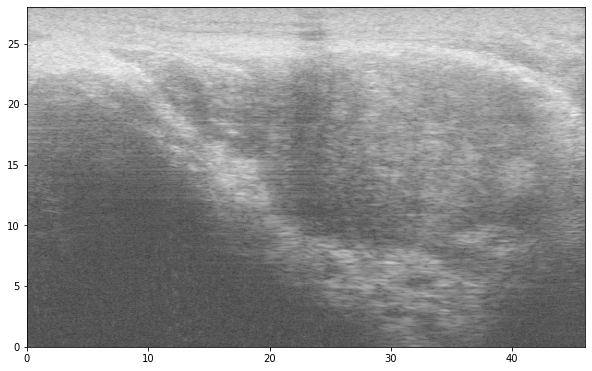

In [107]:
# plot the bmode by itself
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(core.bmode, cmap='gray', extent=[0, 46, 0, 28])


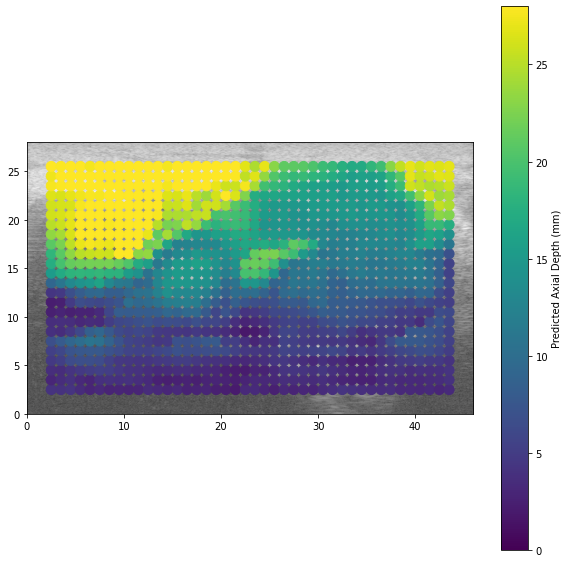

In [100]:
core = patient.get_cores(as_list=True)[1]
centers, depth = plot_core(core, regressor, backbone, T)


(array([ 81., 142.,  98.,  74.,  47.,  51.,  51.,  53.,  82.,  50.,  28.,
         25.,  20.,  20.,  18.,  36.,  41.,  48.,  27.,  16.]),
 array([ 1.758348 ,  3.2940516,  4.829756 ,  6.3654594,  7.901163 ,
         9.436867 , 10.97257  , 12.508274 , 14.043978 , 15.579682 ,
        17.115385 , 18.651089 , 20.186794 , 21.722498 , 23.258202 ,
        24.793905 , 26.329609 , 27.865313 , 29.401016 , 30.93672  ,
        32.472424 ], dtype=float32),
 <BarContainer object of 20 artists>)

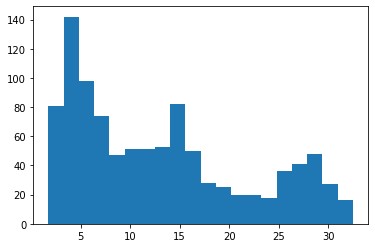

In [101]:
# histogram of the predicted axial depth
plt.hist(depth[:, 0], bins=20)


In [84]:
# plot the cores for the patient
for core in patient.get_cores(as_list=True):
    fig, ax = plot_core(core, regressor, backbone, T)
    plt.show()

KeyboardInterrupt: 